# "Anomaly detection in protocol deviations"
> "When math helps you define *too many* and *too few* protocol deviations."

- toc: false
- branch: master
- badges: true
- comments: false
- author: Yves Barmaz
- categories: [bayesian modeling, clinical quality]

In [1]:
#hide
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [2]:
#hide
data = pd.read_csv('my_data/pdev_data.csv')

Deviations from the approved protocol of a clinical trial are common but need to be reported by investigators to the trial sponsor for review. Failing to do so can put patients at risk and affect the scientific quality of the trial, so detecting protocol deviation underreporting is part of the standard quality assurance activities. Investigator sites that report more deviations than their peers should also raise an alarm as this might indicate underlying quality issues. A statistical tool that quantifies the risk of over- and underreporting of protocol deviations could significantly improve quality activities, much like in the case of [adverse event reporting](https://ybarmaz.github.io/blog/bayesian%20modeling/clinical%20quality/2021/01/08/Probabilistic-assessment-of-safety-underreporting.html).

The number of protocol deviations $n_{pdevs}$ reported by an investigator site should depend linearly on the number of patients $n_{pats}$ enrolled at that site, as more patients mean more chances of deviations, so these are the minimal attributes that should get collected prior to the analysis. The following table is a sample of the data we will use as an example.

In [3]:
#hide_input
data.head()

,site_id,n_pats,n_pdevs
0,site_0,9,15
1,site_1,10,14
2,site_2,15,18
3,site_3,9,10
4,site_4,5,4


A quick glance at the full dataset reveals there is indeed a relationship that looks linear, so a potential approach would be to build a regression model $n_{pdevs} \sim \theta \cdot n_{pats}$ and quantify how every observation of $n_{pdevs}$ deviates from its estimation.

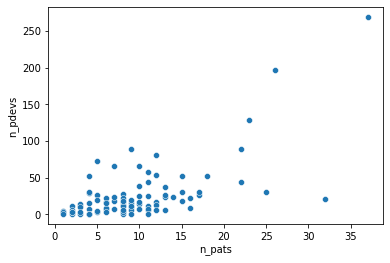

In [4]:
#hide_input
sns.scatterplot(x='n_pats', y='n_pdevs', data=data)
plt.show()

From that scatterplot, it also appears that the residuals of a regression would not be iid. Rather, their variance would grow as the number of patients increases. This rules out least square regression, as it assumes iid normal residuals. Since we are dealing with count data, working with the Poisson distribution is a natural approach,

$$n_{pdevs} \vert n_{pats} \sim Poi(\lambda(n_{pats})),$$

and we can set $\lambda(n_{pats}) = \theta \cdot n_{pats}$ to reflect our assumption of a linear relationship between $n_{pdevs}$ and $n_{pats}$. Note that a regular Poisson regression would fail to capture that linear relationship due to its exponential link function.

In this model, we immediately have $E\left[n_{pdevs} \vert n_{pats}\right] = Var\left[n_{pdevs} \vert n_{pats}\right] = \theta \cdot n_{pats}$, which seems to reproduce the increasing spread of $n_{pdevs}$.

We can infer the value of $\theta$ through maximum likelihood estimation and use the resulting conditional Poisson model at each site to compute the cumulative distribution function (CDF) of the observed numbers of protocol deviations.

In [61]:
#collapse-hide
def loss(par, n_pat, n_dev):
    theta = tf.math.exp(par[0])
    dist = tfd.Poisson(n_pat * theta)
    return -tf.reduce_sum(dist.log_prob(n_dev))

def compute_cdf(par, n_pat, n_dev):
    theta = tf.math.exp(par[0])
    dist = tfd.Poisson(n_pat * theta)
    return dist.cdf(n_dev)

@tf.function
def loss_and_gradient(par, n_pat, n_dev):
    return tfp.math.value_and_gradient(lambda par: loss(par, n_pat, n_dev), par)


def fit(n_pat, n_dev):
    init = 2*tf.ones(1)
    opt = tfp.optimizer.lbfgs_minimize(
        lambda par: loss_and_gradient(par, n_pat, n_dev), init, max_iterations=1000
    )
    return opt

n_pats = tf.constant(data['n_pats'], dtype=tf.float32)
n_pdev = tf.constant(data['n_pdevs'], dtype=tf.float32)

mle = fit(n_pats, n_pdev)

#print(f"converged: {mle.converged}")
#print(f"iterations: {mle.num_iterations}")

x = np.linspace(0, 40)
par = mle.position
y = np.exp(par[0]) * x

cdfs = compute_cdf(par, n_pats, n_pdev)

These CDF values are concentrated around 0 and 1, which makes this approach quite impractical and suggests that the variance of the model is lower than the variance of the data.

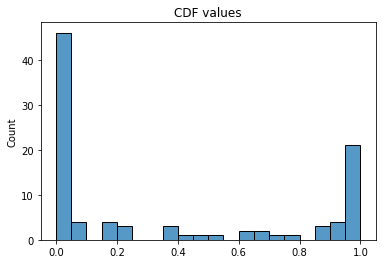

In [62]:
#hide_input
sns.histplot(cdfs, bins=20).set_title('CDF values')
plt.show()

The low variance can be increased by treating $\lambda(n_{pats})$ as a random function, rather than a deterministic one. So we assume that $\lambda(n_{pats})$ is drawn from a gamma distribution, $\lambda(n_{pats}) \sim \Gamma(\alpha, \beta)$, where the rate parameter $\beta$ is inversely proportional to the expected number of protocol deviations from a given site, $\beta = \beta_{pat} / n_{pats}$, in order to ensure linearity in $n_{pats}$. In this context, maximum likelihood estimation would be a nightmare to implement (because of the rate parameters of the Poisson distribution) and probably not very stable, so it is best to turn to Bayesian inference via MCMC algorithms. We thus pick gamma priors for $\alpha$ and $\beta_{pat}$ with a shape parameters of 2 to prevent the corresponding Markov chains from drifting too close to zero, where pathological behaviors seem to occur with more permissive priors in this model.

In [46]:
#collapse-hide
sites = tf.constant(data['site_id'])
n_pats = tf.constant(data['n_pats'], dtype=tf.float32)
n_pdev = tf.constant(data['n_pdevs'], dtype=tf.float32)

mdl_pd = tfd.JointDistributionSequential([
    #alpha
    tfd.Gamma(2, 2, name='alpha'),
    #beta_pt
    tfd.Gamma(2, 2, name='beta_pt'),
    #pdev rates for each patient
    lambda beta_pt, alpha: tfd.Independent(
        tfd.Gamma(alpha[...,tf.newaxis], beta_pt[...,tf.newaxis] / n_pats[tf.newaxis,...]),
        reinterpreted_batch_ndims=1
    ),
    #observed pdevs
    lambda rates: tfd.Independent(tfd.Poisson(rates), reinterpreted_batch_ndims=1)
])

We can sample the posterior distribution of this model with a Hamiltonian Monte Carlo algorithm and assess the convergence of the Markov chains before computing the posterior probabilities of interest.

MCMC acceptance rate: 0.7745


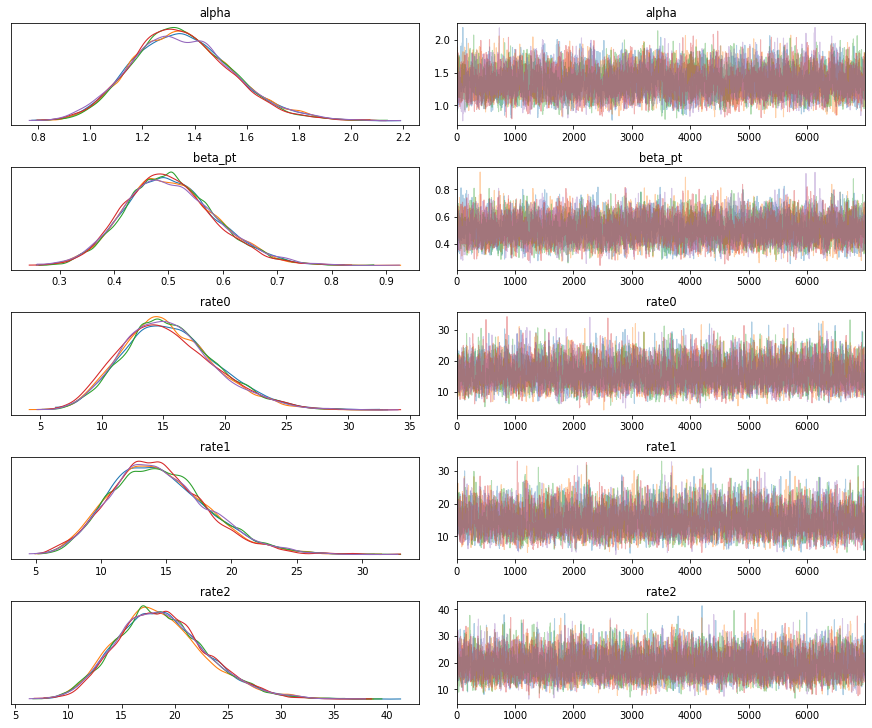

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.35,0.19,1.00,1.71,0.00,0.00,"1,838.00","1,838.00","1,810.00","7,005.00",1.00
beta_pt,0.51,0.08,0.35,0.66,0.00,0.00,"3,012.00","3,012.00","2,930.00","8,825.00",1.00
rate0,15.51,3.83,8.62,22.74,0.05,0.04,"5,800.00","5,800.00","5,545.00","8,565.00",1.00
rate1,14.52,3.74,7.58,21.30,0.05,0.04,"5,415.00","5,415.00","5,203.00","7,654.00",1.00
rate2,18.84,4.28,11.24,27.06,0.05,0.04,"6,743.00","6,743.00","6,539.00","9,273.00",1.00


In [47]:
#collapse-hide
dtype = tf.dtypes.float32
nchain = 5
burnin=3000
num_steps=10000
alpha0, beta_pt0, rates0, _ = mdl_pd.sample(nchain)
init_state = [alpha0, beta_pt0, rates0]
step_size = [tf.cast(i, dtype=dtype) for i in [0.01, 0.01, 0.01]]
target_log_prob_fn = lambda *init_state: mdl_pd.log_prob(
    list(init_state) + [tf.cast(n_pdev, dtype=dtype)])


unconstraining_bijectors = 3*[tfb.Exp()]

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=num_steps, burnin=burnin):
    
    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.is_accepted
               )

    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=3,
        step_size=step_size),
      bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=kernel,
      num_adaptation_steps=burnin
    )

    # Sampling from the chain.
    [alpha, beta_pt, rates], is_accepted = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc,
        trace_fn=trace_fn)
    return alpha, beta_pt, rates, is_accepted

alpha, beta_pt, rates, is_accepted = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

alpha_ = alpha[burnin:,:]
alpha_ = tf.reshape(alpha_, [alpha_.shape[0]*alpha_.shape[1]])
beta_pt_ = beta_pt[burnin:,:]
beta_pt_ = tf.reshape(beta_pt_, [beta_pt_.shape[0]*beta_pt_.shape[1]])
rates_ = rates[burnin:,:]
rates_ = tf.reshape(rates_, [rates_.shape[0]*rates_.shape[1], rates_.shape[2]])

rates_dist_ = tfd.Gamma(alpha_[:,tf.newaxis], beta_pt_[:, tf.newaxis] / n_pats[tf.newaxis,...])
rates_cdf_ = rates_dist_.cdf(rates_)

posterior = {}
posterior['alpha'] = tf.transpose(alpha[burnin:, :]).numpy()
posterior['beta_pt'] = tf.transpose(beta_pt[burnin:, :]).numpy()
posterior['rate0'] = tf.transpose(rates[burnin:, :, 0])
posterior['rate1'] = tf.transpose(rates[burnin:, :, 1])
posterior['rate2'] = tf.transpose(rates[burnin:, :, 2])

az_trace = az.from_dict(posterior=posterior)

print(f'MCMC acceptance rate: {is_accepted.numpy().mean()}')

az.plot_trace(az_trace)
plt.show()

az.summary(az_trace)

Given a Markov chain sample $(\hat\alpha, \hat\beta_{pat}, (\hat\lambda_i)_{i=1,\dots,N})$, where $i$ indexes the investigator sites, we can evaluate the CDF of $\Gamma(\hat\alpha, \hat\beta_{pat} / n_{pats, i})$ at $\hat\lambda_i$ and average these quantities along the whole Markov chain to obtain an indicator of over- and underreporting. This indicator corresponds to the rate tail area of the inferred Poisson rates under their posterior predictive distribution. Low values mean a risk of underreporting, and high values a risk of overreporting (see the last column of the following sample table).

In [49]:
#hide
mean_rates = tf.math.reduce_mean(rates_, axis=0)
std_rates = tf.math.reduce_std(rates_, axis=0)

rates_tail = tf.math.reduce_mean(rates_cdf_, axis=0)

summary_df = pd.DataFrame({'site': sites.numpy().astype(str),
                           'n_pats': n_pats.numpy().astype(int),
                           'n_pdev': n_pdev.numpy().astype(int),
                           'mean_pdev_rate': mean_rates.numpy(),
                           'std_pdev_rate': std_rates.numpy(),
                           'rate_tail_area': rates_tail.numpy()
                          })

In [66]:
#hide_input
pd.options.display.float_format = '{:,.2f}'.format
summary_df.head(10)

,site,n_pats,n_pdev,mean_pdev_rate,std_pdev_rate,rate_tail_area
0,site_0,9,15,15.51,3.83,0.42
1,site_1,10,14,14.52,3.74,0.36
2,site_2,15,18,18.83,4.28,0.31
3,site_3,9,10,10.72,3.20,0.30
4,site_4,5,4,4.96,2.14,0.24
5,site_5,7,19,19.03,4.21,0.61
6,site_6,25,31,31.76,5.60,0.32
7,site_7,2,11,9.90,2.83,0.83
8,site_8,6,7,7.62,2.69,0.31
9,site_9,17,27,27.58,5.14,0.40


The distribution of the rate tail areas looks more convenient than in the first simple model. Not only did we add variance with a mixture model, but we also assess the inferred Poisson parameters rather than the observations, and the former are shrunk by their prior.

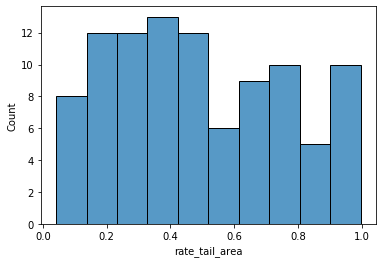

In [52]:
#hide_input
sns.histplot(x='rate_tail_area', data=summary_df, bins=10)
plt.show()

This metric also seems to agree with the intuition of what underreporting and overreporting should look like.

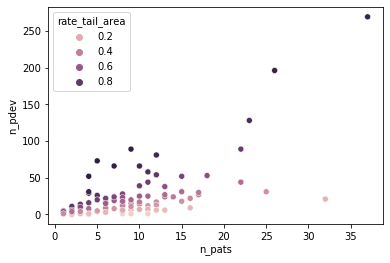

In [55]:
#hide_input
sns.scatterplot(x='n_pats', y='n_pdev', hue='rate_tail_area', data=summary_df)
plt.show()

We can set thresholds for over- and underreporting alerts at .8 and .2 respectively to illustrate how an auditor could use this model to select investigator sites to focus on.

In [56]:
#hide
summary_df['overreporting_alert'] = summary_df['rate_tail_area']>0.8
summary_df['underreporting_alert'] = summary_df['rate_tail_area']<0.2

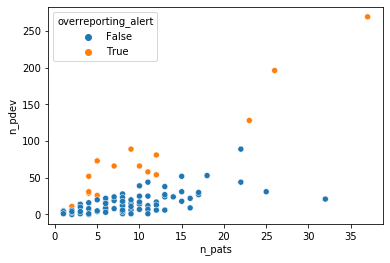

In [57]:
#hide_input
sns.scatterplot(x='n_pats', y='n_pdev', hue='overreporting_alert', data=summary_df)
plt.show()

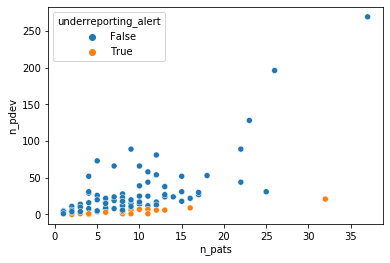

In [58]:
#hide_input
sns.scatterplot(x='n_pats', y='n_pdev', hue='underreporting_alert', data=summary_df)
plt.show()

This method further illustrates the potential of Bayesian analysis to address business problems in a systematic way that combines insights from data with subject matter expertise. Moreover, I found that such models are much easier to explain to stakeholders than black box machine learning, which is a big plus when you advocate for quantitative decision making.